# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torchvision.models import alexnet
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import argparse
from torch.utils.data import TensorDataset, DataLoader
from balanced_loss import Loss

# Pre-Processing

### Real life Data Pre-Processing

We first import one training example and check its validity.

In [2]:
filepath = os.getcwd()+"/Real life data/Pre-processed/EX_0000.npy"
array = np.load(filepath, allow_pickle=True)

print(array[0:2])

[['Square name' 'Image' 'Piece label']
 [1 array([[[102, 118, 120],
            [ 68,  86,  87],
            [ 42,  61,  61],
            ...,
            [116, 122, 122],
            [114, 122, 122],
            [107, 117, 117]],

           [[103, 119, 121],
            [ 65,  84,  85],
            [ 36,  57,  57],
            ...,
            [ 73,  84,  84],
            [ 78,  88,  87],
            [ 89,  99,  98]],

           [[105, 121, 122],
            [ 65,  85,  86],
            [ 31,  53,  54],
            ...,
            [ 47,  63,  62],
            [ 56,  69,  67],
            [ 78,  88,  86]],

           ...,

           [[ 36,  64,  65],
            [ 32,  61,  61],
            [ 31,  60,  60],
            ...,
            [ 67,  84,  84],
            [102, 113, 113],
            [120, 128, 128]],

           [[ 63,  87,  88],
            [ 60,  84,  84],
            [ 59,  83,  83],
            ...,
            [ 59,  78,  78],
            [ 79,  93,  93],
          

In [3]:
print(array[1][1].shape)
print(array[1:, 1].shape)

(130, 130, 3)
(64,)


We will gather all the training examples stored in "Real life data/Pre-processed" and pre process them even further. Each training example after importation is an array consistsing of three elements: the square name (e.g., A1, C3), the image of the square, and the label of the piece placed on the square (if any). The label has a predefined encoding scheme which is the following:
- Empty: 0
- White pawn: 1
- White knight: 2
- White bishop: 3
- White rook: 4
- White queen: 5
- White king: 6
- Black pawn: 7 
- Black knight: 8
- Black bishop: 9
- Black rook: 10
- Black queen: 11
- Black king: 12

Since the square name column is not used in our model, we can discard it from each training example. We can separate the image data and label information by storing them in separate arrays, denoted by 'X_real' and 'y_generated', respectively.

In [4]:
# Create X and y
X_real_life= np.empty((0))
y_real_life = np.empty((0))

# Load data in X and y resepctively 
for i in range(499):
    filepath = os.getcwd()+"/Real life data/Pre-processed/EX_%04d" % i + ".npy"
    t_ex = np.load(filepath, allow_pickle=True) # Load data
    
    X_real_life = np.append(X_real_life, t_ex[1:, 1]) # Append data to X
    y_real_life = np.append(y_real_life, t_ex[1:, 2]) # Append label to y
    

Check the shape of X_real_life and y_real_life and plot the first image with its label as a verification step.

(31936,)
(130, 130, 3)
(31936,)


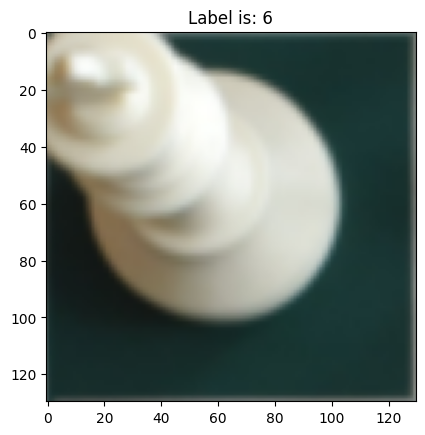

In [5]:
print(X_real_life.shape)
print(X_real_life[6].shape)
print(y_real_life.shape)

# Plot the image
plt.imshow(X_real_life[6])
plt.title("Label is: "+str(y_real_life[6]))
plt.show()

We will now split the real-life dataset into training, validation and testing datasets. This will be done using the sklearn.train_test_split method. We then check the shapes of each set.

In [6]:
# split the dataset into train, validation, and test sets
X_real_life_train_val, X_real_life_test, y_real_life_train_val, y_real_life_test = train_test_split(X_real_life, y_real_life, test_size=0.3, random_state=42)
X_real_life_train, X_real_life_val, y_real_life_train, y_real_life_val = train_test_split(X_real_life_train_val, y_real_life_train_val, test_size=0.3/(0.4+0.3), random_state=42)

print("X_real_life_train size is: ", X_real_life_train.shape)
print("y_real_life_train size is: ", y_real_life_train.shape)

print("X_real_life_val size is: ", X_real_life_val.shape)
print("y_real_life_val size is: ", y_real_life_val.shape)

print("X_real_life_test size is: ", X_real_life_test.shape)
print("y_real_life_test size is: ", y_real_life_test.shape)


X_real_life_train size is:  (12774,)
y_real_life_train size is:  (12774,)
X_real_life_val size is:  (9581,)
y_real_life_val size is:  (9581,)
X_real_life_test size is:  (9581,)
y_real_life_test size is:  (9581,)


Define the dataloaders: we need a dataloader for both the source (generated data) and the target (real-life data). Here we will create the dataloader for thge real-life dataset.

In [7]:
def get_real_life_dataloader(batch_size, train=True):
    # create Tensor datasets
    train_data = TensorDataset(torch.Tensor(X_real_life_train), torch.Tensor(y_real_life_train))
    val_data = TensorDataset(torch.Tensor(X_real_life_val), torch.Tensor(y_real_life_val))
    test_data = TensorDataset(torch.Tensor(X_real_life_test), torch.Tensor(y_real_life_test))

    # create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=train)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=train)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=train)

    return train_loader, val_loader, test_loader

### Generated Data Pre-Processing

We first import one training example and check its validity.

In [8]:
filepath = os.getcwd()+"/Data Generation/Data Generated/Dataset PreProcessed/EX_0000.npy"
array = np.load(filepath, allow_pickle=True)

print(array[0:2])

[['Square Name' 'Image' 'Piece Label']
 ['A1' array([[[115, 122, 121, 255],
               [100, 109, 109, 255],
               [ 87,  98,  98, 255],
               ...,
               [105, 114, 112, 255],
               [111, 119, 118, 255],
               [118, 125, 124, 255]],

              [[100, 109, 108, 255],
               [ 79,  92,  91, 255],
               [ 61,  78,  76, 255],
               ...,
               [ 85,  97,  96, 255],
               [104, 113, 111, 255],
               [121, 127, 126, 255]],

              [[ 86,  98,  96, 255],
               [ 60,  77,  75, 255],
               [ 39,  59,  58, 255],
               ...,
               [ 68,  83,  81, 255],
               [ 94, 105, 103, 255],
               [119, 126, 124, 255]],

              ...,

              [[ 65,  71,  71, 255],
               [ 45,  53,  52, 255],
               [ 34,  42,  42, 255],
               ...,
               [ 87,  99,  97, 255],
               [109, 117, 116, 255],
    

In [9]:
print(array[1][1].shape)
print(array[1:, 1].shape)

(130, 130, 4)
(64,)


We will gather all the training examples stored in "Data Generated/ Dataset PreProcessed" and pre process them even further. Each training example after importation is an array consistsing of three elements: the square name (e.g., A1, C3), the image of the square, and the label of the piece placed on the square (if any). The label has a predefined encoding scheme which is the following:
- Empty: 0
- White pawn: 1
- White knight: 2
- White bishop: 3
- White rook: 4
- White queen: 5
- White king: 6
- Black pawn: 7 
- Black knight: 8
- Black bishop: 9
- Black rook: 10
- Black queen: 11
- Black king: 12

Since the square name column is not used in our model, we can discard it from each training example. We can separate the image data and label information by storing them in separate arrays, denoted by 'X_target' and 'y_target', respectively.

In [10]:
# Create X and y
X_generated = np.empty((0))
y_generated = np.empty((0))

# Load data in X and y resepctively 
for i in range(100):
    filepath = os.getcwd()+"/Data Generation/Data Generated/Dataset PreProcessed/EX_%04d" % i + ".npy"
    t_ex = np.load(filepath, allow_pickle=True) # Load data
    
    X_generated = np.append(X_generated, t_ex[1:, 1]) # Append data to X
    y_generated = np.append(y_generated, t_ex[1:, 2]) # Append label to y

    

Check the shape of X_generated and y_generated and plot the first image with its label as a verification step.

(6400,)
(130, 130, 4)
(6400,)


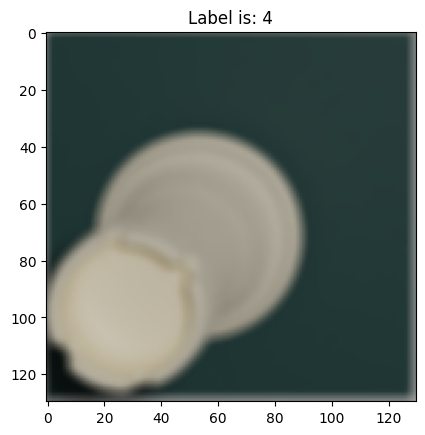

In [11]:
print(X_generated.shape)
print(X_generated[0].shape)
print(y_generated.shape)

# Plot the image
plt.imshow(X_generated[0])
plt.title("Label is: "+str(y_generated[0]))
plt.show()

Similarly as for the real-life dataset, we will generate the dataloaders for the generated dataset.

In [12]:
def get_generated_dataloader(batch_size, train=True):
    # create Tensor datasets
    train_data = TensorDataset(torch.Tensor(X_generated), torch.Tensor(y_generated))

    # create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=train)

    return train_loader

# Data Analysis

We will now plot the data distribution of both the real-life dataset and the generated dataset. We expect a lot of the data to be empty squares with label '0' in both dataset. We want to check that the distribution of the chess pieces are similar in both datasets or not.

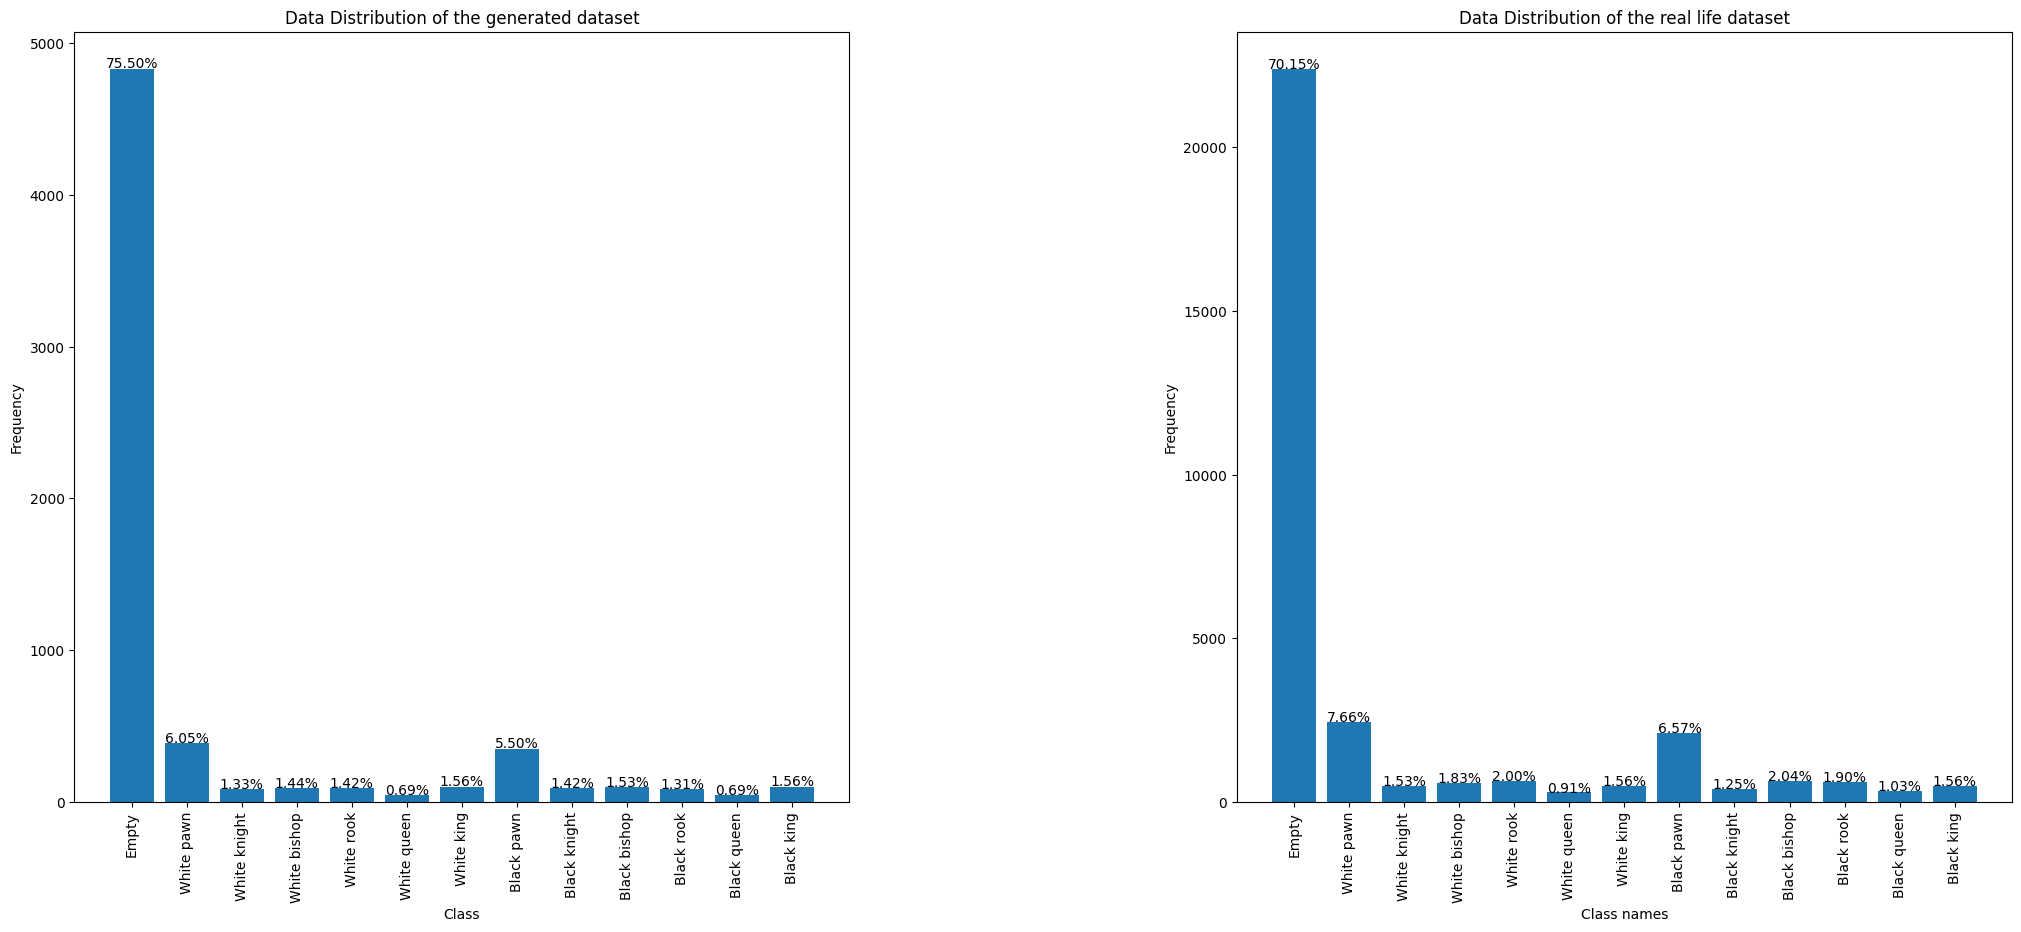

In [13]:
# create a dictionary that maps class numbers to their names
class_names = {0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
               5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
               10: 'Black rook', 11: 'Black queen', 12: 'Black king'}

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# plot the first histogram on the left subplot
hist, bins, _ = ax1.hist(y_generated, bins=range(14), align='left', rwidth=0.8)
ax1.set_xticks(list(class_names.keys()))
ax1.set_xticklabels(list(class_names.values()), rotation='vertical')
ax1.set_xlabel('Class')
ax1.set_ylabel('Frequency')
ax1.set_title('Data Distribution of the generated dataset')

# Store the count of each class in an array to define the losses later
samples_per_class_generated = hist

# add count number above each bar
for i in range(len(class_names)):
    ax1.text(i, (hist[i])+5, "{:.2f}%".format(int(hist[i]*100)/y_generated.shape[0]), ha='center')

# plot the second histogram on the right subplot
hist2, bins2, _ = ax2.hist(y_real_life, bins=range(14), align='left', rwidth=0.8)
ax2.set_xticks(list(class_names.keys()))
ax2.set_xticklabels(list(class_names.values()), rotation='vertical')
ax2.set_xlabel('Class names')
ax2.set_ylabel('Frequency')
ax2.set_title('Data Distribution of the real life dataset')

# Store the count of each class in an array to define the losses later
samples_per_class_real_life = hist2

# add count number above each bar
for i in range(len(class_names)):
    ax2.text(i, (hist2[i])+5, "{:.2f}%".format(int(hist2[i])*100/y_real_life.shape[0]), ha='center')

# adjust the layout of the subplots
plt.subplots_adjust(wspace=0.5)

# show the plot
plt.show()

As anticipated, it is observed that there are numerous empty squares in both datasets. Additionally, the distribution of White and Black pawns in both datasets is remarkably similar. Moreover, the distribution of each class appears to be quite similar when comparing the two datasets. However, it is noted that the generated dataset has a greater number of empty square labels (76% compare to 70%).

# Model Implementation

We first define the Loss functions we will use when training our model. As previously demonstrated in the pre-processing section, the dataset is heavily imbalanced, with around 70% of training examples containing empty squares. In view of this, for the classification task, the class-balanced focal loss will be utilized, which effectively balances the loss across the sample classes. Utilization of this loss will result in improved evaluation of the model's loss. The equation defining this loss is as follows:

* First the effective number of samples are calculated for all classes as:

$$
E_{n} = \frac{1-\beta^{n}}{1-\beta}
$$

* Then the class balanced loss fucntion is defined as:

$$
L_{cb} (p,y) = \frac{1}E_{n_{y}}(-\frac{1}{N}\sum_{i=1}^{N}\alpha_{i}(1-p_{i})^{\gamma}\log(p_{i}))
$$

So we have:
$$
L_{cb} (p,y) = \frac{1-\beta}{1-\beta^{n_{y}}}(-\frac{1}{N}\sum_{i=1}^{N}\alpha_{i}(1-p_{i})^{\gamma}\log(p_{i}))
$$

This loss function is already implemented in the "Loss" package in balanced_loss which we imported. We need to specify the number of examples for each class. 

In [19]:
# Define the class-balanced focal losses. 
# One for each dataset since they both have different number of samples per class
focal_real_life_Loss = Loss(
    loss_type="focal_loss",
    samples_per_class=samples_per_class_real_life,
    class_balanced=True
)

focal_real_life_Loss = Loss(
    loss_type="focal_loss",
    samples_per_class=samples_per_class_generated,
    class_balanced=True
)

We now define the coral loss along with a helper function computing covariance. Coral loss is a type of distance metric used to align two sets of feature representations. It stands for "correlation alignment".

The Coral loss aims to minimize the domain shift between two distributions by aligning the second-order statistics of their features. It computes the covariance matrix of the source and target features and then minimizes the Frobenius norm between the difference of the two covariance matrices. This way, the correlation between the features is preserved and domain shift is reduced.

The Coral loss can be formulated as:

$$
L_{coral}(X_s, X_t) = \frac{1}{4d^2}\lVert C_s - C_t \rVert_{F}^2
$$

where $X_s$ and $X_t$ are the source and target feature representations respectively, $d$ is the number of features in each representation, and $C_s$ and $C_t$ are the covariance matrices of the source and target features.

In addition to the loss function, a helper function can be defined to compute the covariance matrix:

$$
C(X) = \frac{1}{n-1}(X-\bar{X})^T(X-\bar{X})
$$

where $X$ is a matrix of feature representations and $\bar{X}$ is the mean of each feature. The covariance matrix $C(X)$ can then be computed using the formula above.

In [20]:
# The compute_covariance function takes an input data tensor 
# and returns its covariance matrix. 
# The formula for the covariance matrix is given by
# c = (X^T*X - (1/n)*1*(1^T*X)*(1^T*X)^T)/(n-1), 
# where X is the input data tensor. 
# This function first calculates the mean of the columns of the input
#  data tensor, and then uses it to calculate the covariance matrix.
 
def compute_covariance(input_data):
    """
    Compute Covariance matrix of the input data
    """
    # first calculates the batch size n of the input data.
    n = input_data.size(0)  # batch_size

    # Check if using gpu or cpu
    # assigns the appropriate device accordingly
    if input_data.is_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Create a tensor of size (1, n) with all elements equal to 1, and moves it to the device.
    id_row = torch.ones(n).resize(1, n).to(device=device)

    # calculate the sum of columns of the input data
    # and divide it by n to get the mean of columns mean_column
    # (1/n)*(1^T*X)
    mean = torch.div(torch.mm(id_row, input_data), n)

    # tensor which is the multiplication of the mean of columns with its transpose
    # (1/n)*(1^T*X)*(1^T*X)^T
    term_mul_2 = torch.mm(mean.t(), mean)

    # Calculate the matrix product of the transpose of input data tensor with itself.
    # X^T*X
    XTX = torch.mm(input_data.t(), input_data)

    # Calculate the covariance matrix c
    # c = (X^T*X - (1/n)*(1^T*X)*(1^T*X)^T)/(n-1)
    c = torch.add(XTX, (-1 * term_mul_2)) * 1 / (n - 1)

    # Return the covariance matrix
    return c

# The coral function takes two input data tensors,
#  source and target, and returns the CORAL loss.
#  The CORAL loss is given by
#  loss = sum((c_s - c_t)^2)/(4*d^2),
#  where c_s and c_t are the covariance matrices of the source and target data respectively,
#  and d is the dimension of the input data.
def coral(source, target):

    # first calculates the dimension of the input data d
    d = source.size(1)  # dim vector

    # Calculate the covariance matrices of the source and target data
    source_c = compute_covariance(source)
    target_c = compute_covariance(target)

    # Calculate the CORAL loss
    # loss = sum((c_s - c_t)^2)
    loss = torch.sum(torch.mul((source_c - target_c), (source_c - target_c)))

    # loss = sum((c_s - c_t)^2)/(4*d^2)
    loss = loss / (4 * d * d)
    # Return the CORAL loss
    return loss

In [16]:
from utils import accuracy, Tracker

def train(model, optimizer, source_loader, target_loader, tracker, args, epoch=0):

    model.train()
    tracker_class, tracker_params = tracker.MovingMeanMonitor, {'momentum': 0.99}

    # Trackers to monitor classification and CORAL loss
    classification_loss_tracker = tracker.track('classification_loss', tracker_class(**tracker_params))
    coral_loss_tracker = tracker.track('CORAL_loss', tracker_class(**tracker_params))

    min_n_batches = min(len(source_loader), len(target_loader))

    tq = tqdm(range(min_n_batches), desc='{} E{:03d}'.format('Training + Adaptation', epoch), ncols=0)

    for _ in tq:

        source_data, source_label = next(iter(source_loader))
        target_data, _ = next(iter(target_loader))  # Unsupervised Domain Adaptation

        source_data, source_label = Variable(source_data.to(device=args.device)), Variable(source_label.to(device=args.device))
        target_data = Variable(target_data.to(device=args.device))

        optimizer.zero_grad()

        out_source = model(source_data)
        out_target = model(target_data)

        classification_loss = F.cross_entropy(out_source, source_label)

        # This is where the magic happens
        coral_loss = coral(out_source, out_target)
        composite_loss = classification_loss + args.lambda_coral * coral_loss

        composite_loss.backward()
        optimizer.step()

        classification_loss_tracker.append(classification_loss.item())
        coral_loss_tracker.append(coral_loss.item())
        fmt = '{:.4f}'.format
        tq.set_postfix(classification_loss=fmt(classification_loss_tracker.mean.value),
                       coral_loss=fmt(coral_loss_tracker.mean.value))


def evaluate(model, data_loader, dataset_name, tracker, args, epoch=0):
    model.eval()

    tracker_class, tracker_params = tracker.MeanMonitor, {}
    acc_tracker = tracker.track('{}_accuracy'.format(dataset_name), tracker_class(**tracker_params))

    loader = tqdm(data_loader, desc='{} E{:03d}'.format('Evaluating on %s' % dataset_name, epoch), ncols=0)

    accuracies = []
    with torch.no_grad():
        for target_data, target_label in loader:
            target_data = Variable(target_data.to(device=args.device))
            target_label = Variable(target_label.to(device=args.device))

            output = model(target_data)

            accuracies.append(accuracy(output, target_label))

            acc_tracker.append(sum(accuracies)/len(accuracies))
            fmt = '{:.4f}'.format
            loader.set_postfix(accuracy=fmt(acc_tracker.mean.value))


def main():

    # Paper: In the training phase, we set the batch size to 128,
    # base learning rate to 10−3, weight decay to 5×10−4, and momentum to 0.9

    parser = argparse.ArgumentParser(description='Train - Evaluate DeepCORAL model')
    parser.add_argument('--disable_cuda', action='store_true',
                        help='Disable CUDA')
    parser.add_argument('--epochs', type=int, default=50,
                        help='Number of total epochs to run')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='Batch size')
    parser.add_argument('--lr', default=1e-3,
                        help='Learning Rate')
    parser.add_argument('--decay', default=5e-4,
                        help='Decay of the learning rate')
    parser.add_argument('--momentum', default=0.9,
                        help="Optimizer's momentum")
    parser.add_argument('--lambda_coral', type=float, default=0.5,
                        help="Weight that trades off the adaptation with "
                             "classification accuracy on the source domain")
    parser.add_argument('--source', default='amazon',
                        help="Source Domain (dataset)")
    parser.add_argument('--target', default='webcam',
                        help="Target Domain (dataset)")

    args = parser.parse_args()
    args.device = None

    if not args.disable_cuda and torch.cuda.is_available():
        args.device = torch.device('cuda')
    else:
        args.device = torch.device('cpu')

    source_train_loader = get_loader(name_dataset=args.source, batch_size=args.batch_size, train=True)
    target_train_loader = get_loader(name_dataset=args.target, batch_size=args.batch_size, train=True)

    source_evaluate_loader = get_loader(name_dataset=args.source, batch_size=args.batch_size, train=False)
    target_evaluate_loader = get_loader(name_dataset=args.target, batch_size=args.batch_size, train=False)

    n_classes = len(source_train_loader.dataset.classes)

    # ~ Paper : "We initialized the other layers with the parameters pre-trained on ImageNet"
    # check https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
    model = alexnet(pretrained=True)
    # ~ Paper : The dimension of last fully connected layer (fc8) was set to the number of categories (31)
    model.classifier[6] = nn.Linear(4096, n_classes)
    # ~ Paper : and initialized with N(0, 0.005)
    torch.nn.init.normal_(model.classifier[6].weight, mean=0, std=5e-3)

    # Initialize bias to small constant number (http://cs231n.github.io/neural-networks-2/#init)
    model.classifier[6].bias.data.fill_(0.01)

    model = model.to(device=args.device)

    # ~ Paper : "The learning rate of fc8 is set to 10 times the other layers as it was training from scratch."
    optimizer = torch.optim.SGD([
        {'params':  model.features.parameters()},
        {'params': model.classifier[:6].parameters()},
        # fc8 -> 7th element (index 6) in the Sequential block
        {'params': model.classifier[6].parameters(), 'lr': 10 * args.lr}
    ], lr=args.lr, momentum=args.momentum)  # if not specified, the default lr is used

    tracker = Tracker()

    for i in range(args.epochs):
        train(model, optimizer, source_train_loader, target_train_loader, tracker, args, i)
        evaluate(model, source_evaluate_loader, 'source', tracker, args, i)
        evaluate(model, target_evaluate_loader, 'target', tracker, args, i)

    # Save logged classification loss, coral loss, source accuracy, target accuracy
    torch.save(tracker.to_dict(), "log.pth")


if __name__ == '__main__':
    main()

ModuleNotFoundError: No module named 'utils'